In [1]:
!pip install pyunpack
!pip install patool

     |████████████████████████████████| 81kB 2.1MB/s 


In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from google.colab import files

In [3]:
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


In [19]:
import zipfile
import numpy as np
from matplotlib import pyplot as plt
import cv2
import os
from sklearn.model_selection import train_test_split
from skimage.color import rgb2lab, lab2rgb, gray2rgb
from skimage.transform import resize
import matplotlib.animation as animation

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import torchvision
from torchvision import transforms, utils
import torchvision.models as models

In [5]:
import tarfile
my_tar = tarfile.open('gdrive/My Drive/Colorization_dataset/dataset.tar.tar')
my_tar.extractall('./') # specify which folder to extract to
my_tar.close()

In [2]:
print(len(os.listdir('images/Train/')), len(os.listdir('images/Test/')))

9294 494


In [3]:
train_datapath = 'images/Train/'
val_datapath = train_datapath

In [4]:
file_list = list(sorted(os.listdir(train_datapath)))
length = len(file_list)
train_file_list = file_list[0:length-500]
val_file_list = file_list[-500:]

In [5]:
print(len(train_file_list), len(val_file_list))

8794 500


In [6]:
im_path = train_datapath + train_file_list[0]
image_bgr = cv2.imread(im_path).astype("float32")/255.0
image_rgb = cv2.cvtColor(image_bgr, cv2.COLOR_BGR2RGB)
image_lab = rgb2lab(image_rgb)

In [7]:
class MyDataset(torch.utils.data.Dataset):
    def __init__(self, datapath, file_list, transforms=None):
        self.datapath = datapath             
        self.transforms = transforms

        self.files_list = file_list
        
    def __len__(self):
        return len(self.files_list)

    def __getitem__(self, index):
        image_fname = self.datapath  + self.files_list[index]
        
        image_bgr = cv2.imread(image_fname).astype("float32")/255.0 #<H,W,#channels>
        image_rgb = cv2.cvtColor(image_bgr, cv2.COLOR_BGR2RGB)
        
        image_lab = rgb2lab(image_rgb) #lab format

        image_gray = image_lab[:,:,0]
        image_target = image_lab[:,:,1::]

        if self.transforms is not None:
            image_gray, image_target = self.transforms(image_gray, image_target)

        return image_gray, image_target #  np arrays

    def __call__(self, index=None):
        if index is None:
            index = np.random.choice(len(self.files_list))
            print(f"showing filenamed:{self.files_list[index]}, index:{index}")

        image_fname = self.datapath + self.files_list[index]
        image_bgr = cv2.imread(image_fname).astype("float32")/255.0 #<H,W,#channels>
        image_rgb = cv2.cvtColor(image_bgr, cv2.COLOR_BGR2RGB)

        image_lab = rgb2lab(image_rgb) #lab format

        image_gray = image_lab[:,:,0]
        image_target = image_lab[:,:,1::]
        
        
        fig, ax = plt.subplots(4, figsize=(15,20))
        ax[0].imshow(image_rgb)
        ax[0].axis('off')

        ax[1].imshow(image_gray)
        ax[1].axis('off')

        ax[2].imshow(image_target[:,:,0])
        ax[2].axis('off')

        ax[3].imshow(image_target[:,:,1])
        ax[3].axis('off')

        print(image_gray.shape, image_target.shape)
        print(np.amax(image_gray), np.amin(image_gray))
        print(np.amax(image_target[:,:,0]), np.amin(image_target[:,:,0]))
        print(np.amax(image_target[:,:,1]), np.amin(image_target[:,:,1]))

In [8]:
class ToTensor():    
    def __call__(self, image, target):
        inp = image/100.0
        image = np.zeros((inp.shape[0], inp.shape[1], 3), dtype=np.float32)
        image[:,:,0] = inp
        image[:,:,1] = inp
        image[:,:,2] = inp
        #image = image[:,:,3] # adding channel dim=1 to grayscale image
        image = image.transpose((2,0,1))
        target = target.transpose((2,0,1))/128.0
        image = torch.tensor(image).type(torch.float)
        target = torch.tensor(target).type(torch.float)
        
        return image, target

class Resize():
    def __call__(self, image, target, shape=224):
        image = cv2.resize(image, (shape, shape))
        target = cv2.resize(target, (shape, shape))
        return image, target
        
class Compose():
    def __init__(self, transforms):
        self.transforms = transforms

    def __call__(self, image, target):
        for t in self.transforms:
            image, target = t(image, target)
        return image, target

In [9]:
train_transform_compose = Compose([Resize(), ToTensor()])
val_transform_compose = Compose([Resize(), ToTensor()])
#test_transform_compose = Compose([ToTensor()])

showing filenamed:RO7aMC.jpg, index:4786
(256, 256) (256, 256, 2)
98.93242 0.03957367
21.889479 -18.687546
27.744818 -28.096437


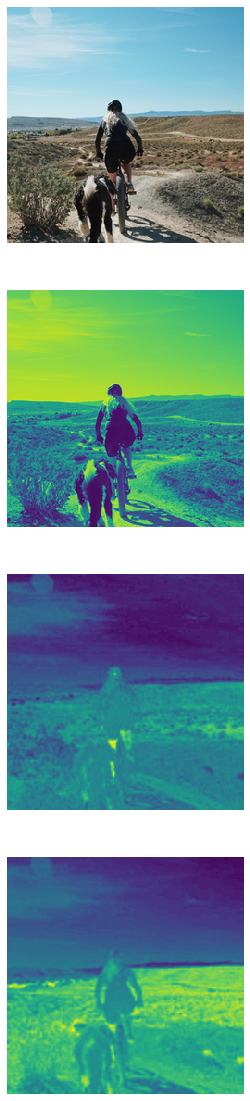

In [10]:
train_dataset = MyDataset(train_datapath, train_file_list, transforms=train_transform_compose)
train_dataset()

showing filenamed:rsIW4Y.jpg, index:43
(256, 256) (256, 256, 2)
99.82896 0.2332344
62.56968 -13.769031
56.150497 -15.505302


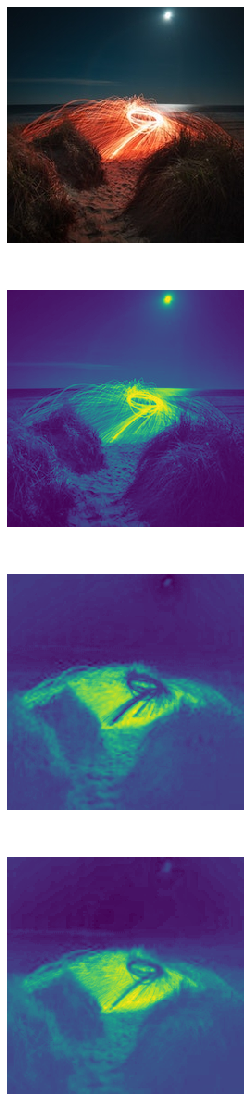

In [11]:
val_dataset = MyDataset(val_datapath, val_file_list, transforms=val_transform_compose)
val_dataset()

In [12]:
bs = 128

In [13]:
# train dataloader
train_dataloader = DataLoader(train_dataset, batch_size=bs, shuffle=True)
# test dataloader
val_dataloader = DataLoader(val_dataset, batch_size=bs, shuffle=True)

In [14]:
print(len(train_dataloader), len(val_dataloader))

69 4


In [15]:
# Encoder-Decoder Params
latent_dims = 256

In [16]:
class AE(nn.Module):
  def __init__(self, latent_dims=128):
    super().__init__()
    #self.resnet18_enc = nn.Sequential(*list(models.resnet18().children())[0:8], \
    #                                  nn.Conv2d(512, latent_dims, kernel_size=1))
    
    self.resnet18_enc = nn.Sequential(*list(models.resnet18(pretrained=True).children())[0:8])
    
    for n, m in self.resnet18_enc.named_parameters(): #  freezing all except last layer
        if str(8) not in n:
            m.requires_grad = False


    '''self.decoder = nn.Sequential(
                  nn.ConvTranspose2d(latent_dims, 128, kernel_size=3, padding=1, bias=False),
                  nn.BatchNorm2d(128),
                  nn.LeakyReLU(),
                  nn.ConvTranspose2d(128, 64, kernel_size=3, stride=2, padding=1, output_padding=1, bias=False),
                  nn.BatchNorm2d(64),
                  nn.LeakyReLU(),
                  nn.ConvTranspose2d(64, 32, kernel_size=3, stride=2, padding=1, output_padding=1, bias=False),
                  nn.BatchNorm2d(32),
                  nn.LeakyReLU(),
                  nn.ConvTranspose2d(32, 16, kernel_size=3, stride=2, padding=1, output_padding=1, bias=False),
                  nn.BatchNorm2d(16),
                  nn.LeakyReLU(),
                  nn.ConvTranspose2d(16, 8, kernel_size=3, stride=2, padding=1, output_padding=1, bias=False),
                  nn.BatchNorm2d(8),
                  nn.LeakyReLU(),
                  nn.ConvTranspose2d(8, 2, kernel_size=3, stride=2, padding=1, output_padding=1, bias=False),
                  nn.Tanh()
                  
    )'''


    self.decoder = nn.Sequential(
                  nn.ConvTranspose2d(512, 256, kernel_size=3, padding=1, bias=False),
                  nn.BatchNorm2d(256),
                  nn.LeakyReLU(),
                  nn.ConvTranspose2d(256, 128, kernel_size=3, padding=1, bias=False),
                  nn.BatchNorm2d(128),
                  nn.LeakyReLU(),
                  nn.ConvTranspose2d(128, 64, kernel_size=3, stride=2, padding=1, output_padding=1, bias=False),
                  nn.BatchNorm2d(64),
                  nn.LeakyReLU(),
                  nn.ConvTranspose2d(64, 32, kernel_size=3, stride=2, padding=1, output_padding=1, bias=False),
                  nn.BatchNorm2d(32),
                  nn.LeakyReLU(),
                  nn.ConvTranspose2d(32, 16, kernel_size=3, stride=2, padding=1, output_padding=1, bias=False),
                  nn.BatchNorm2d(16),
                  nn.LeakyReLU(),
                  nn.ConvTranspose2d(16, 8, kernel_size=3, stride=2, padding=1, output_padding=1, bias=False),
                  nn.BatchNorm2d(8),
                  nn.LeakyReLU(),
                  nn.ConvTranspose2d(8, 2, kernel_size=3, stride=2, padding=1, output_padding=1, bias=True),
                  nn.Tanh()
                  
    )

  def forward(self, x):
      x = self.resnet18_enc(x)
      x = self.decoder(x)
      return x

ae = AE(latent_dims=128)

In [17]:
lr=1e-3
# setting up device
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

# setting optimizer
params = [p for p in  ae.parameters() if p.requires_grad]
optimizer = torch.optim.Adam(params, lr=lr)
#optimizer = torch.optim.SGD(params, lr=lr,
#                            momentum=0.9, weight_decay=0.0005)

# and a learning rate scheduler which decreases the learning rate by
# 0.5x every 3 epochs
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=8, gamma=0.5)

# set the model on device
ae.to(device)

# criterion
criterion = nn.MSELoss() #nn.SmoothL1Loss() #nn.MSELoss()

**Search for learning rate**

In [ ]:
def lr_finder(model, optimizer, start_lr, end_lr, dataloader, beta=0.98, terminate_factor = 10, device='cpu'):
  '''
  model: model object
  optimizer: optimizer object
  start_lr: starting learning rate, say 1e-8
  end_lr: ending learning rate, say 1
  dataloader: dataloader object
  beta: smoothing parameter for exponential averaging of the loss
  terminate_factor : if smooth loss computed > terminate_factor*best_loss, then return
  device: cpu or gpu
  '''
  model.train()
  # compute the mult factor which needs to be multiplied with start_lr
  num = len(dataloader)-1  
  mult_fac = (end_lr/start_lr)**(1/num)
  lr = start_lr
  optimizer.param_groups[0]['lr'] = lr

  # define list to store the smooth loss and learning rate
  smooth_loss_list  = []
  lr_list = []
  batch_num = 0
  avg_loss = 0
  best_loss = 0

  for images, targets in dataloader:
    batch_num += 1
    
    images = images.to(device)
    targets = targets.to(device)

    # zero out the gradients
    optimizer.zero_grad()
    # forward pass and compute the loss
    
    op = model(images)
    # compute loss
    losses = criterion(op, targets)
    

    # average the loss based on beta
    avg_loss = beta*avg_loss + (1-beta)*losses.data
    # de-embedd the starting bias
    smooth_loss = avg_loss/(1-beta**batch_num)

    # stop if loss is exploding
    if batch_num > 1 and smooth_loss > terminate_factor*best_loss:
      print("loss diverging, terminating early...")
      return smooth_loss_list, lr_list

    # record the best loss
    if smooth_loss < best_loss or batch_num == 1:
      best_loss = smooth_loss

    print(f'batch_num:{batch_num}, avg_loss:{avg_loss}, smooth_loss:{smooth_loss}, lr:{lr}')

    smooth_loss_list.append(smooth_loss)
    lr_list.append(lr)

    # backward pass
    losses.backward()
    # update optimizer
    optimizer.step()

    
    # update lr for next step
    lr *= mult_fac
    optimizer.param_groups[0]['lr'] = lr

  return smooth_loss_list, lr_list

In [ ]:
start_lr =1e-6
end_lr = 5
loss_list, lr_list = lr_finder(ae, optimizer, start_lr, end_lr, train_dataloader, beta=0.98, terminate_factor = 10, device= device)

batch_num:1, avg_loss:0.0029635154642164707, smooth_loss:0.14817577600479126, lr:1e-06
batch_num:2, avg_loss:0.005876759998500347, smooth_loss:0.14840303361415863, lr:1.2546259464317832e-06
batch_num:3, avg_loss:0.00872347503900528, smooth_loss:0.14833824336528778, lr:1.5740862654598478e-06
batch_num:4, avg_loss:0.011475460603833199, smooth_loss:0.14781899750232697, lr:1.9748894705678327e-06
batch_num:5, avg_loss:0.014234073460102081, smooth_loss:0.14814937114715576, lr:2.4777475711093307e-06
batch_num:6, avg_loss:0.016922488808631897, smooth_loss:0.1482379287481308, lr:3.108646391422096e-06
batch_num:7, avg_loss:0.01958056166768074, smooth_loss:0.14847879111766815, lr:3.900188420959695e-06
batch_num:8, avg_loss:0.022158173844218254, smooth_loss:0.14847643673419952, lr:4.89327758890884e-06
batch_num:9, avg_loss:0.024678515270352364, smooth_loss:0.1484401971101761, lr:6.139233026138188e-06
batch_num:10, avg_loss:0.027111805975437164, smooth_loss:0.14821091294288635, lr:7.702441045783886

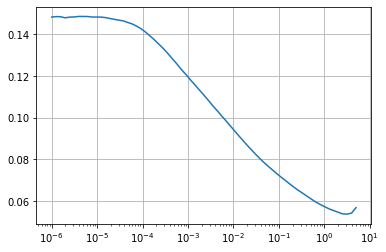

In [ ]:
plt.figure()
plt.semilogx(lr_list, loss_list)
plt.grid(True)

In [22]:
lr = 1e-3
epochs = 100
optimizer = torch.optim.Adam(params, lr=lr)
scheduler_1 = torch.optim.lr_scheduler.CyclicLR(optimizer, base_lr=1e-3, max_lr=1e-2, step_size_up=len(train_dataloader)//2,\
                                                cycle_momentum=False)

In [23]:
def train_one_epoch(model, dataloader, optimizer, device, epoch_num, scheduler=None):
    # set the model in train mode
    model.train()
    num_batches = len(dataloader)
    batch_num = 0
    losses = []
    for images, targets in dataloader: # returns batch of data every iteration

      # send images in this batch to device
      #imgs = list(image.to(device) for image in images) # list of images
      # send target in this batch to device
      #tgts = list(target.to(device) for target in targets) # list of dict

      images = images.to(device)
      targets = targets.to(device)
      
      # zero out the gradients so that they do not accumulate (default behaviour) in successive passes
      optimizer.zero_grad()
      
      # forward pass
      op = model(images)
      # compute loss
      mse_loss = criterion(op, targets) 
      #print(f'loss:{mse_loss}')
      # run backward pass
      mse_loss.backward()
      # update optimizer
      optimizer.step() 
      # step the schedureif enabled
      if scheduler is not None:
          scheduler.step()
       
      batch_num += 1
      print(f'Epoch:{epoch_num}, Train_batch:{batch_num}/{num_batches}, loss:{mse_loss}')
      losses.append(mse_loss.detach().item())
    return losses, mse_loss

In [24]:
# dummy forward pass
#loss, mse_loss = train_one_epoch(autoencoder, train_dataloader, optimizer, device, epoch_num=0)

In [25]:
def eval(model, dataloader, optimizer, device, epoch_num):
    # set the model in train mode
    model.eval()
    num_batches = len(dataloader)
    batch_num = 0
    losses = []
    for images, targets in dataloader: # returns batch of data every iteration
      with torch.no_grad():
        images = images.to(device)
        targets = targets.to(device)
        # forward pass
        op = model(images)
        # compute loss
        mse_loss = criterion(op, targets) 
             
        batch_num += 1
        print(f'Epoch:{epoch_num}, Eval_batch:{batch_num}/{num_batches}, loss:{mse_loss.item()}')
        losses.append(mse_loss.item())
    return losses

In [26]:
xx = torch.randn(64,3,224,224).type(torch.FloatTensor).to(device)
y = ae(xx)
y.shape

torch.Size([64, 2, 224, 224])

In [27]:
train_loss_list = []
val_loss_list = []
best_val_loss = 1e9

for epoch_num in range(epochs):
  train_loss, _ = train_one_epoch(ae, train_dataloader, optimizer, device, epoch_num, scheduler_1)
    
  # run learning rate scheduler step if defined
  #if lr_scheduler is not None:
  #  lr_scheduler.step()
  #  print(f"learning rate set to: {optimizer.param_groups[0]['lr']}")

  # evaluate on the test dataset
  val_loss   = eval(ae, val_dataloader, optimizer, device, epoch_num)
  # add loss to list
  train_loss_epoch = sum(train_loss)/len(train_dataloader)
  val_loss_epoch = sum(val_loss)/len(val_dataloader)
  print(f'Epoch:{epoch_num}, train_loss_avg:{train_loss_epoch}')
  print(f'Epoch:{epoch_num}, val_loss_avg:{val_loss_epoch}')
  train_loss_list.append(train_loss_epoch)
  val_loss_list.append(val_loss_epoch)

  if val_loss_epoch < best_val_loss:
    torch.save(ae.state_dict(), 'checkpoint_model.pth')
    torch.save(optimizer.state_dict(), 'checkpoint_opt.pth')
    best_val_loss = val_loss_epoch
    print(f'Saving model at epoch: {epoch_num}')
    

Streaming output truncated to the last 5000 lines.
Epoch:33, Train_batch:27/69, loss:0.005015690810978413
Epoch:33, Train_batch:28/69, loss:0.00560818100348115
Epoch:33, Train_batch:29/69, loss:0.0056384047493338585
Epoch:33, Train_batch:30/69, loss:0.005538686644285917
Epoch:33, Train_batch:31/69, loss:0.0053841532208025455
Epoch:33, Train_batch:32/69, loss:0.006368148140609264
Epoch:33, Train_batch:33/69, loss:0.006194677669554949
Epoch:33, Train_batch:34/69, loss:0.005884502548724413
Epoch:33, Train_batch:35/69, loss:0.004236800130456686
Epoch:33, Train_batch:36/69, loss:0.005943060852587223
Epoch:33, Train_batch:37/69, loss:0.004908210597932339
Epoch:33, Train_batch:38/69, loss:0.005492605734616518
Epoch:33, Train_batch:39/69, loss:0.005654123146086931
Epoch:33, Train_batch:40/69, loss:0.006016266532242298
Epoch:33, Train_batch:41/69, loss:0.006095272023230791
Epoch:33, Train_batch:42/69, loss:0.006597914267331362
Epoch:33, Train_batch:43/69, loss:0.006887589581310749
Epoch:33, Tra

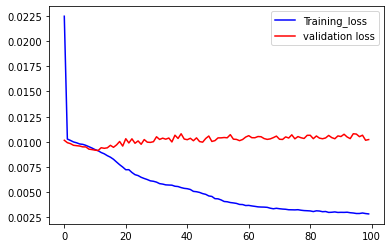

In [28]:
plt.figure()
plt.plot(train_loss_list,'b', label='Training_loss')
plt.plot(val_loss_list, 'r', label='validation loss')
plt.legend()

In [18]:
ae.load_state_dict(torch.load('checkpoint_model_100.pth'))

<All keys matched successfully>

torch.Size([1, 2, 224, 224])


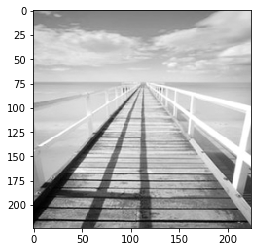

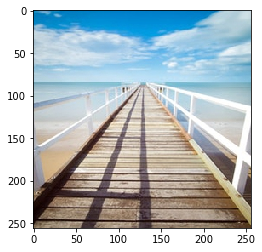

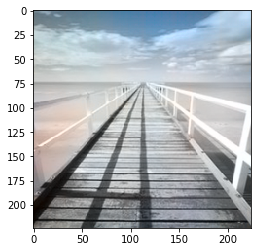

In [19]:
#pick an image from validation set
indx = np.random.choice(len(val_dataset))
input_imagepath = val_datapath + val_dataset.files_list[indx]
input_image_bgr = cv2.imread(input_imagepath).astype('float32')/255.0
input_image_rgb = cv2.cvtColor(input_image_bgr, cv2.COLOR_BGR2RGB)

image_lab = rgb2lab(input_image_rgb) #lab format

image_gray = image_lab[:,:,0]
image_gray = cv2.resize(image_gray, (224,224))

# pass the input through network
input_image = np.zeros((224,224,3))
input_image[:,:,0] = image_gray/100.0
input_image[:,:,1] = image_gray/100.0
input_image[:,:,2] = image_gray/100.0
input_image = input_image.transpose(2,0,1)
input_image = torch.tensor(input_image).type(torch.float)
input_image = input_image[None,:,:,:]

ae.eval()
with torch.no_grad():
  input_image = input_image.to(device)
  pred_image = ae(input_image)
  #print(pred_image.shape)

pred_image = pred_image[0,:,:,:].cpu().numpy() #ab channel
pred_im = np.zeros((3,224,224), dtype=np.float32)
input_image = input_image.cpu().numpy()
pred_im[0,:,:] = input_image[0,0,:,:] * 100.0
pred_im[1:,:,:] = pred_image * 128
pred_im = pred_im.transpose(1,2,0)
pred_im_rgb = lab2rgb(pred_im)

plt.figure()
plt.imshow(image_gray,cmap='gray')

plt.figure()
plt.imshow(input_image_rgb)

plt.figure()
plt.imshow(pred_im_rgb)

In [31]:
pred_image[0,:,:]

array([[ 0.00161168,  0.00085451, -0.00133611, ..., -0.00811603,
        -0.00658685, -0.00584373],
       [ 0.0003567 , -0.00060983, -0.00149885, ..., -0.01005068,
        -0.01074952, -0.00706641],
       [-0.00231889, -0.00292275, -0.00359608, ..., -0.01411107,
        -0.01004227, -0.00838651],
       ...,
       [ 0.00695797,  0.00725835,  0.00940624, ..., -0.00572276,
        -0.01680684, -0.01064617],
       [ 0.00834743,  0.00895453,  0.00797904, ..., -0.00377807,
         0.00412646,  0.00466362],
       [ 0.01043448,  0.00871376,  0.00834083, ...,  0.00121246,
         0.00865304,  0.00309566]], dtype=float32)

torch.Size([1, 2, 224, 224])


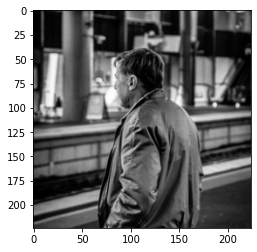

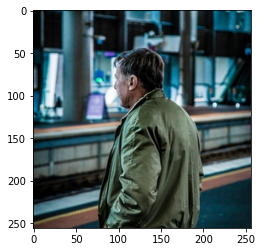

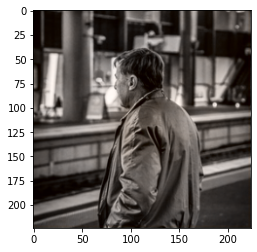

In [44]:
#pick an image from training set
indx = np.random.choice(len(train_dataset))
input_imagepath = train_datapath + train_dataset.files_list[indx]
input_image_bgr = cv2.imread(input_imagepath).astype('float32')/255.0
input_image_rgb = cv2.cvtColor(input_image_bgr, cv2.COLOR_BGR2RGB)

image_lab = rgb2lab(input_image_rgb) #lab format

image_gray = image_lab[:,:,0]
image_gray = cv2.resize(image_gray, (224,224))

# pass the input through network
input_image = np.zeros((224,224,3))
input_image[:,:,0] = image_gray/100.0
input_image[:,:,1] = image_gray/100.0
input_image[:,:,2] = image_gray/100.0
input_image = input_image.transpose(2,0,1)
input_image = torch.tensor(input_image).type(torch.float)
input_image = input_image[None,:,:,:]

ae.eval()
with torch.no_grad():
  input_image = input_image.to(device)
  pred_image = ae(input_image)
  print(pred_image.shape)

pred_image = pred_image[0,:,:,:].cpu().numpy() #ab channel
pred_im = np.zeros((3,224,224), dtype=np.float32)
input_image = input_image.cpu().numpy()
pred_im[0,:,:] = input_image[0,0,:,:] * 100.0
pred_im[1:,:,:] = pred_image * 128.0
pred_im = pred_im.transpose(1,2,0)
#pred_im = pred_im.astype('uint8')
pred_im_rgb = lab2rgb(pred_im)

plt.figure()
plt.imshow(image_gray, cmap='gray')

plt.figure()
plt.imshow(input_image_rgb)

plt.figure()
plt.imshow(pred_im_rgb)

In [35]:
#torch.save(optimizer.state_dict(), 'checkpoint_opt_ep100.pth')

In [36]:
#torch.save(ae.state_dict(), 'checkpoint_model_100.pth')

In [25]:
def save_op(datapath, file_list, model, save_path, saveflag=0, max_count=500):
    l_ = len(file_list)
    im = []
    for i, file in enumerate(file_list):
        input_imagepath = datapath + file
        input_image_bgr = cv2.imread(input_imagepath).astype('float32')/255.0
        input_image_rgb = cv2.cvtColor(input_image_bgr, cv2.COLOR_BGR2RGB)

        image_lab = rgb2lab(input_image_rgb) #lab format

        image_gray = image_lab[:,:,0]
        image_gray = cv2.resize(image_gray, (224,224))

        # pass the input through network
        input_image = np.zeros((224,224,3))
        input_image[:,:,0] = image_gray/100.0
        input_image[:,:,1] = image_gray/100.0
        input_image[:,:,2] = image_gray/100.0
        input_image = input_image.transpose(2,0,1)
        input_image = torch.tensor(input_image).type(torch.float)
        input_image = input_image[None,:,:,:]

        model.eval()
        with torch.no_grad():
          input_image = input_image.to(device)
          pred_image = ae(input_image)
          #print(pred_image.shape)

        pred_image = pred_image[0,:,:,:].cpu().numpy() #ab channel
        pred_im = np.zeros((3,224,224), dtype=np.float32)
        input_image = input_image.cpu().numpy()
        pred_im[0,:,:] = input_image[0,0,:,:] * 100.0
        pred_im[1:,:,:] = pred_image * 128
        pred_im = pred_im.transpose(1,2,0)
        pred_im_rgb = lab2rgb(pred_im)
        
        #fig = plt.figure(figsize=(10,10))        
        ax1 = fig.add_subplot(1,3,1)
        im1 = ax1.imshow(image_gray, cmap='gray')
        ax2 = fig.add_subplot(1,3,2)
        im2 = ax2.imshow(input_image_rgb, cmap='gray')
        ax3 = fig.add_subplot(1,3,3)
        im3 = ax3.imshow(pred_im_rgb)
        im.append([im1, im2, im3])
        if saveflag:
            fname = save_path + str(i) + '.png'
            fig.savefig(fname, bbox_inches = 'tight', pad_inches = 0)   
            print(f"saved: {i}/{l_}...")        
        if i > max_count:
            break
    return im

C:\Continuum\anaconda3\envs\fastai_v1\lib\site-packages\ipykernel_launcher.py:38: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
C:\Continuum\anaconda3\envs\fastai_v1\lib\site-packages\ipykernel_launcher.py:40: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
C:\Continuum\anaconda3\envs\fastai_v1\lib\site-packages\ipykernel_launcher.py:42: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently

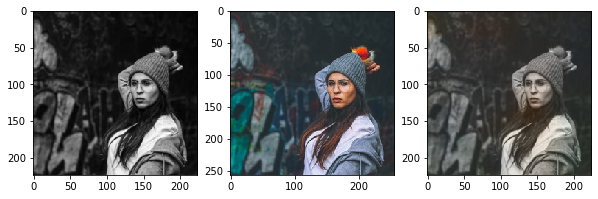

In [26]:
fig = plt.figure(figsize=(10,10))
plt.ioff()
save_path = 'Results_val/'
ims = save_op(datapath=val_datapath, file_list=val_dataset.files_list, model=ae, save_path=save_path, saveflag=0)
ani = animation.ArtistAnimation(fig, ims, interval=1000, blit=True,
                                repeat_delay=1000)
ani.save("val_movie.mp4")

C:\Continuum\anaconda3\envs\fastai_v1\lib\site-packages\ipykernel_launcher.py:38: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
C:\Continuum\anaconda3\envs\fastai_v1\lib\site-packages\ipykernel_launcher.py:40: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
C:\Continuum\anaconda3\envs\fastai_v1\lib\site-packages\ipykernel_launcher.py:42: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently

C:\Continuum\anaconda3\envs\fastai_v1\lib\site-packages\skimage\color\colorconv.py:1128: UserWarning: Color data out of range: Z < 0 in 20 pixels
  return xyz2rgb(lab2xyz(lab, illuminant, observer))
C:\Continuum\anaconda3\envs\fastai_v1\lib\site-packages\skimage\color\colorconv.py:1128: UserWarning: Color data out of range: Z < 0 in 1687 pixels
  return xyz2rgb(lab2xyz(lab, illuminant, observer))
C:\Continuum\anaconda3\envs\fastai_v1\lib\site-packages\skimage\color\colorconv.py:1128: UserWarning: Color data out of range: Z < 0 in 10 pixels
  return xyz2rgb(lab2xyz(lab, illuminant, observer))
C:\Continuum\anaconda3\envs\fastai_v1\lib\site-packages\skimage\color\colorconv.py:1128: UserWarning: Color data out of range: Z < 0 in 207 pixels
  return xyz2rgb(lab2xyz(lab, illuminant, observer))


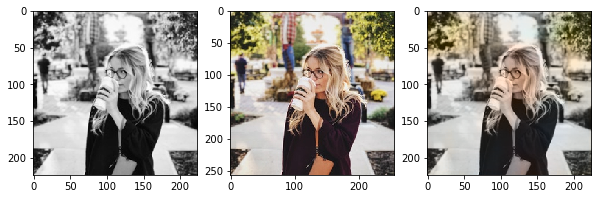

In [27]:
fig = plt.figure(figsize=(10,10))
plt.ioff()
save_path = 'Results_train/'
ims = save_op(datapath=train_datapath, file_list=train_dataset.files_list, model=ae, save_path=save_path, saveflag=0)
ani = animation.ArtistAnimation(fig, ims, interval=1000, blit=True,
                                repeat_delay=1000)
ani.save("train_movie.mp4")